### Poisson Gamma Mixture (NBD)

In [1]:
# user inputs
num_obs = 10000
gamma_shape = 2
gamma_rate = 4
nbd_p_derived = 1 / (1+gamma_rate)

In [2]:
# packages
from scipy import stats as st
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import arviz as az
from IPython.core.pylabtools import figsize
import pymc3 as pm

In [3]:
# generate some simulated numbers
x_gamma = st.gamma.rvs(a=gamma_shape, scale=1/gamma_rate, size=num_obs)
x_poisson_gamma_mixture = np.concatenate([st.poisson.rvs(x, size=1) for x in x_gamma])

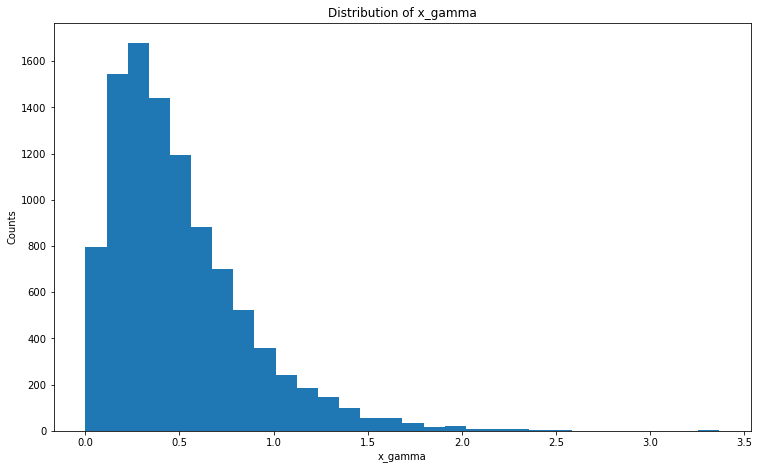

In [4]:
# distribution of x_gamma
figsize(12.5, 7.5)
plt.hist(x_gamma, bins=30)
plt.xlabel("x_gamma")
plt.ylabel("Counts")
plt.title("Distribution of x_gamma")
plt.show()

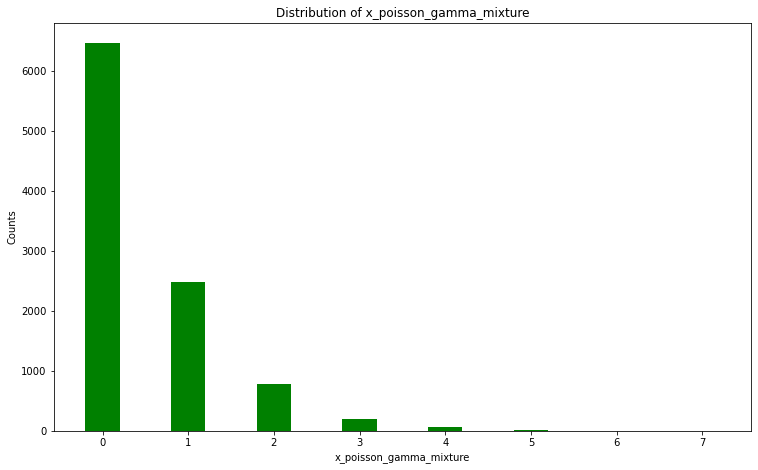

In [5]:
counts = np.bincount(x_poisson_gamma_mixture)
values = np.nonzero(counts)[0]
plt.bar(values, counts, color="green", width=0.4)
plt.xlabel("x_poisson_gamma_mixture")
plt.ylabel("Counts")
plt.title("Distribution of x_poisson_gamma_mixture")
plt.show()

In [6]:
print("Mean value of x_poisson_gamma_mixture: %f" % x_poisson_gamma_mixture.mean())
print("Mean value of x_poisson_gamma_mixture: %f" % x_poisson_gamma_mixture.var())
print("Mean value of implied NBD: %f" % (gamma_shape*nbd_p_derived/(1-nbd_p_derived)))
print("Mean value of implied NBD: %f" % (gamma_shape*nbd_p_derived/(1-nbd_p_derived)**2))

Mean value of x_poisson_gamma_mixture: 0.498100
Mean value of x_poisson_gamma_mixture: 0.648796
Mean value of implied NBD: 0.500000
Mean value of implied NBD: 0.625000


In [7]:
# estimating mle
def nbd_neg_ll(nbd_parameters):
    n, p = nbd_parameters[0], nbd_parameters[1]
    neg_ll = -np.sum(st.nbinom.logpmf(x_poisson_gamma_mixture, n=n, p=p))
    return(neg_ll)

# minimimze
initial_parameters = st.uniform.rvs(size=2)
optimal_result = minimize(nbd_neg_ll, initial_parameters, method="Nelder-Mead", options={"disp":True})
print("Initial n: %f, Initial p: %f" %(optimal_result.x[0], optimal_result.x[1]))
print("Final n: %f, Final p: %f" %(optimal_result.x[0], 1-optimal_result.x[1]))
print("Implied n: %f, Implied p: %f" % (gamma_shape, nbd_p_derived))

Optimization terminated successfully.
         Current function value: 9496.024507
         Iterations: 61
         Function evaluations: 114
Initial n: 1.658210, Initial p: 0.769003
Final n: 1.658210, Final p: 0.230997
Implied n: 2.000000, Implied p: 0.200000


In [8]:
# estimating posterior using MCMC
nbd_model = pm.Model()
with nbd_model:
    poisson_lambda = pm.Gamma("poisson_lambda", alpha=gamma_shape, beta=gamma_rate)
    observation = pm.Poisson("observation", poisson_lambda, observed=x_poisson_gamma_mixture)
    trace = pm.sample(10000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [poisson_lambda]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.


                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
poisson_lambda  0.498  0.007   0.485    0.512        0.0      0.0    8342.0   

                ess_sd  ess_bulk  ess_tail  r_hat  
poisson_lambda  8342.0    8314.0   14186.0    1.0  


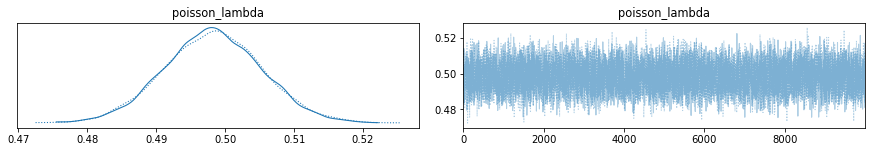

In [9]:
# posterior distribution
with nbd_model:
    axes_arr = az.plot_trace(trace)
    print(az.summary(trace))

plt.draw()

In [10]:
with nbd_model:
    ppc = pm.sample_posterior_predictive(trace, samples=1000, var_names=["poisson_lambda","observation"])    

/home/tanmay/Software/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


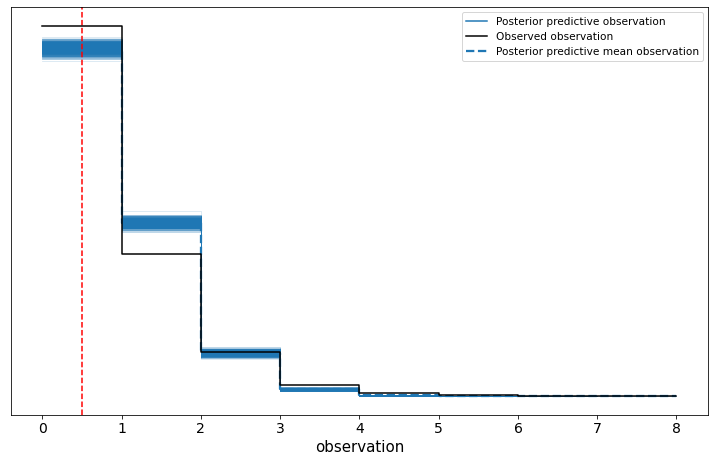

In [11]:
fig, ax = plt.subplots()
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=nbd_model), ax=ax)
ax.axvline(x_poisson_gamma_mixture.mean(), ls="--", color='r', label="True mean")